# Creative extension
We have asked ourselves two research questions:

- [[Task A]](#Task-A): Do Machine Learning-based classification approaches find similar positive treatment effects as the regression analyses of the paper? In other words, do we reach the same conclusions as the researchers if we try to classify households as treatment or control based on the dependent variables?

- [[Task B]](#Task-B): Is it possible to predict the most important variables from the 2005 survey using only data from the 2000 census?


Reference to the [paper](https://www.aeaweb.org/articles?id=10.1257/pol.1.1.75):

Matias D. Cattaneo, Sebastian Galiani, Paul J. Gertler, Sebastian Martinez, and Rocio Titiunik. Housing, health, and happiness. American Economic Journal: Economic Policy, 1(1):75–105, February 2009.

# Task A

Our task A consists in two main goals:
1. Compare the predictive performances of the different _outcome variables_ specified in Tables 4 and 6 of the paper to predict whether a household is from the treatment of control group.

To achieve this, we first build a baseline model that only includes control variables, i.e. features from the 2000 census, and features from the 2005 survey that are used either in their regression model 3 or as robustness checks in Table 7 of the paper. 
50 such features were selected.
The task consists in predicting whether an household is from the treatment or control group based on these features. The target feature is therefore the _intention-to-treat_ feature, referred as `dpisofirme` throughout the code.

Our expectation is that the baseline model should not perform well because the authors provided ample evidences that treatment and control households are well balanced over these control variables. As we will see, our models could actually exploit the differences in these control variables and perform very well on this baseline case.

Then we construct a model for each _outcome variable_, i.e. a model that includes the outcome variable as covariate besides the control variables. 
In the paper, the intention-to-treat variable is shown to be important to predict the outcome variables, hence we expect that including an outcome variable in the model should improve our predictions of the intention-to-treat variable. 
As you will see, we could not observe such an effect because the baseline predictions were already perfect.

2. Compare the feature importances of the _outcome variables_ with the regression coefficients from the paper

To achieve this, we perform a feature importance analysis on the models explained above and obtain an importance score for each outcome variable.
Then we compare first qualitatively the importance ranking of the outcome variables using our importance scores with the ranking based on the paper's regression coefficients.
It turns out that they agree relatively well.
We then compare them quantitatively and they agree pretty well too.

### Outline of Task A
- [Task A](#Task-A)
    - [Import libraries](#Import-libraries)
    - [Load the dataset](#Load-the-dataset)
    - [Preprocessing of the dataset](#Preprocessing-of-the-dataset)
    - [Select features](#Select-features)
    - [Split into train and test sets](#Split-into-train-and-test-sets)
    - [Assess the missingness in train and test sets](#Assess-the-missingness-in-train-and-test-sets)
    - [Preprocessing of the features](#Preprocessing-of-the-features)
    - [Construct and fit the classifiers](#Construct-and-fit-the-classifiers)
    - [Comparison of the predictive performances](#Comparison-of-the-predictive-performances)
    - [Comparison of our feature importances with their _intention-to-treatment_ coefficients](#Comparison-of-our-feature-importances-with-their-intention-to-treatment-coefficients)

## Import libraries

Let's start by importing the usual good stuff. 
The only custom import is the module `variables`, which contains the names of the necessary variables for each part of the notebook. 
Importing them in this way avoids cluttering the notebook's cells.

In [18]:
import os
import sys
import time
import re
from collections import defaultdict 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 41)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

%load_ext autoreload
%autoreload 2

In [ ]:
DATA_PATH = os.path.join('..', 'data')
FIGURES_PATH = os.path.join('..', 'figures')
SCRIPTS_PATH = os.path.join('..', 'src')

# Enable access to modules in scripts directory
sys.path.append(os.path.abspath(SCRIPTS_PATH))

# `variables` contains the necessary variables to use for each table
import variables

## Load the dataset

In [64]:
hh_df = pd.read_stata(os.path.join(DATA_PATH, 'PisoFirme_AEJPol-20070024_household.dta'))

The `hh_df` dataset contains information at the households level. It contains 2783 households and 78 features:

In [65]:
print(hh_df.shape)
hh_df.head()

(2783, 78)


dpisofirme   idcluster    coord_x    coord_y  idmun  idmza  \
0         0.0  70000537.0 -103.50367  25.583067    7.0     40   
1         0.0  70000537.0 -103.50367  25.583067    7.0     40   
2         0.0  70000537.0 -103.50367  25.583067    7.0     40   
3         0.0  70000537.0 -103.50367  25.583067    7.0     47   
4         0.0  70000537.0 -103.50367  25.583067    7.0     47   

   C_blocksdirtfloor  C_HHdirtfloor  C_child05  C_households  C_people  \
0                0.3       0.036629   0.555554         819.0    3530.0   
1                0.3       0.036629   0.555554         819.0    3530.0   
2                0.3       0.036629   0.555554         819.0    3530.0   
3                0.3       0.036629   0.555554         819.0    3530.0   
4                0.3       0.036629   0.555554         819.0    3530.0   

    C_rooms  C_HHpersons  C_waterland  C_waterhouse  C_waterbath  C_gasheater  \
0  3.097682     4.310134     0.002443      0.151522     0.272279     0.004885   
1  3.097682     4.310134     0.002443      0.151522     0.272279     0.004885   
2  3.097682     4.310134     0.002443      0.151522     0.272279     0.004885   
3  3.097682     4.310134     0.002443      0.151522     0.272279     0.004885   
4  3.097682     4.310134     0.002443      0.151522     0.272279     0.004885   

   C_refrigerator  C_washing  C_telephone  ...  S_dem8  S_seguropopular  \
0        0.114775   0.247868     0.524304  ...     0.0              0.0   
1        0.114775   0.247868     0.524304  ...     0.0              0.0   
2        0.114775   0.247868     0.524304  ...     0.0              0.0   
3        0.114775   0.247868     0.524304  ...     0.0              0.0   
4        0.114775   0.247868     0.524304  ...     0.0              0.0   

   S_shcementfloor  S_cementfloorkit  S_cementfloordin  S_cementfloorbat  \
0              0.6               1.0               0.0               1.0   
1              1.0               1.0               1.0               1.0   
2              1.0               1.0               1.0               1.0   
3              1.0               1.0               1.0               1.0   
4              1.0               1.0               1.0               1.0   

   S_cementfloorbed  S_satisfloor  S_satishouse  S_satislife  S_cesds  S_pss  \
0               0.0           1.0           1.0          1.0     14.0   12.0   
1               1.0           0.0           0.0          0.0     17.0   24.0   
2               1.0           1.0           1.0          1.0     16.0   16.0   
3               1.0           1.0           1.0          1.0     20.0   19.0   
4               1.0           1.0           1.0          1.0      4.0    5.0   

   S_instcement  S_instsanita  S_restsanita  S_constceili  S_restowalls  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   S_improveany  S_logrent  S_logsell  
0           0.0   5.298317   9.903487  
1           0.0   5.298317   9.615806  
2           0.0   6.214608  10.819778  
3           0.0  11.385092  11.918390  
4           0.0   5.703783  10.819778  

[5 rows x 78 columns]

## Preprocessing of the dataset

As always, we start by preprocessing the dataset.
Here we proceed as the authors specify at the top of page 82. 
More precisely, we remove the households with missing geographical information.

The dataset contains initially 1393 and 1390 households from the control and treatment groups respectively:

In [66]:
(hh_df['dpisofirme'] == 0).sum(), (hh_df['dpisofirme'] == 1).sum()

(1393, 1390)

Let's remove the households with missing geographical location information as indicated by the authors:

In [67]:
hh_df.dropna(subset=['idcluster'], inplace=True)

In [68]:
(hh_df['dpisofirme'] == 0).sum(), (hh_df['dpisofirme'] == 1).sum()

(1393, 1362)

We are left with 1393 and 1362 households from the control and treatment groups.

## Select features

In [69]:
control_variables = variables.control_variables
table_4_outcomes = variables.table_4_outcomes
table_6_outcomes = variables.table_6_outcomes

In [70]:
outcome_variables = table_4_outcomes + table_6_outcomes

In [71]:
df = hh_df.loc[:, control_variables + outcome_variables + ['dpisofirme']].copy()

In [72]:
df

S_instsanita  S_restsanita  S_constceili  S_restowalls  S_improveany  \
0              0.0           0.0           0.0           0.0           0.0   
1              0.0           0.0           0.0           0.0           0.0   
2              0.0           0.0           0.0           0.0           0.0   
3              0.0           0.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
2750           0.0           0.0           1.0           0.0           1.0   
2751           0.0           0.0           0.0           0.0           0.0   
2752           0.0           0.0           0.0           0.0           0.0   
2753           0.0           0.0           0.0           0.0           0.0   
2754           0.0           0.0           0.0           0.0           0.0   

      S_logrent  S_logsell  C_blocksdirtfloor  C_HHdirtfloor  C_child05  \
0      5.298317   9.903487           0.300000       0.036629   0.555554   
1      5.298317   9.615806           0.300000       0.036629   0.555554   
2      6.214608  10.819778           0.300000       0.036629   0.555554   
3     11.385092  11.918390           0.300000       0.036629   0.555554   
4      5.703783  10.819778           0.300000       0.036629   0.555554   
...         ...        ...                ...            ...        ...   
2750   5.298317   9.615806           0.538462       0.100774   0.759924   
2751   5.991465  10.819778           0.538462       0.100774   0.759924   
2752   5.991465   9.210340           0.538462       0.100774   0.759924   
2753   6.396930  11.918390           0.538462       0.100774   0.759924   
2754   5.298317   9.903487           0.833333       0.354845   1.000010   

      C_households  C_people   C_rooms  C_HHpersons  C_waterbath  C_gasheater  \
0            819.0    3530.0  3.097682     4.310134     0.272279     0.004885   
1            819.0    3530.0  3.097682     4.310134     0.272279     0.004885   
2            819.0    3530.0  3.097682     4.310134     0.272279     0.004885   
3            819.0    3530.0  3.097682     4.310134     0.272279     0.004885   
4            819.0    3530.0  3.097682     4.310134     0.272279     0.004885   
...            ...       ...       ...          ...          ...          ...   
2750         454.0    1866.0  3.264429     4.110127     0.333881     0.022024   
2751         454.0    1866.0  3.264429     4.110127     0.333881     0.022024   
2752         454.0    1866.0  3.264429     4.110127     0.333881     0.022024   
2753         454.0    1866.0  3.264429     4.110127     0.333881     0.022024   
2754          31.0     144.0  1.709684     4.645164     0.709665     0.129048   

      C_refrigerator  C_washing  C_telephone  C_vehicle  ...  S_electricity  \
0           0.114775   0.247868     0.524304   0.644129  ...              1   
1           0.114775   0.247868     0.524304   0.644129  ...              1   
2           0.114775   0.247868     0.524304   0.644129  ...              1   
3           0.114775   0.247868     0.524304   0.644129  ...              1   
4           0.114775   0.247868     0.524304   0.644129  ...              1   
...              ...        ...          ...        ...  ...            ...   
2750        0.113730   0.286599     0.660113   0.534601  ...              1   
2751        0.113730   0.286599     0.660113   0.534601  ...              1   
2752        0.113730   0.286599     0.660113   0.534601  ...              1   
2753        0.113730   0.286599     0.660113   0.534601  ...              1   
2754        0.322577   0.483887     1.000000   0.935481  ...              1   

      S_hasanimals  S_animalsinside  S_garbage  S_washhands  S_cashtransfers  \
0              1.0              0.0        1.0          3.0             0.00   
1              0.0              0.0        1.0          3.0             0.00   
2     

Let's see how many binary features we have.

In [73]:
binary_variables = [col for col in df.columns[df.nunique() == 2] if col != 'dpisofirme']
numeric_variables = list(df.columns[df.nunique() > 2])
print(f"There are {len(binary_variables)} binary features and "
      f"{len(numeric_variables)} numeric features in total.")

There are 21 binary features and 39 numeric features in total.


## Split into train and test sets

We first split our dataset into a train and a test set containing respectively 80% and 20% of the data.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df[control_variables + outcome_variables], df['dpisofirme'], 
                                                    train_size=0.8, random_state=2020)

## Assess the missingness in train and test sets

In [75]:
def missingness_summary_for_df(df):
    return pd.concat([df.isna().sum(), df.isna().mean()], axis=1).rename(
        columns={0: 'missingness_count', 1: 'missingness_fraction'})

Let's look at the missingness of the numeric variables:

In [76]:
missingness_summary_for_df(X_train[numeric_variables]).join(missingness_summary_for_df(X_test[numeric_variables]), 
                                                            lsuffix='_train', rsuffix='_test')

missingness_count_train  missingness_fraction_train  \
S_logrent                              148                    0.067151   
S_logsell                              229                    0.103902   
C_blocksdirtfloor                      140                    0.063521   
C_HHdirtfloor                          140                    0.063521   
C_child05                              140                    0.063521   
C_households                           140                    0.063521   
C_people                               140                    0.063521   
C_rooms                                140                    0.063521   
C_HHpersons                            140                    0.063521   
C_waterbath                            140                    0.063521   
C_gasheater                            140                    0.063521   
C_refrigerator                         140                    0.063521   
C_washing                              140                    0.063521   
C_telephone                            140                    0.063521   
C_vehicle                              140                    0.063521   
C_overcrowding                         140                    0.063521   
C_poverty                              140                    0.063521   
C_illiterate                           140                    0.063521   
C_dropouts515                          140                    0.063521   
C_employment                           140                    0.063521   
C_earnincome                           140                    0.063521   
S_HHpeople                               0                    0.000000   
S_headage                                0                    0.000000   
S_spouseage                              0                    0.000000   
S_headeduc                               4                    0.001815   
S_spouseeduc                           271                    0.122958   
S_dem1                                   1                    0.000454   
S_dem2                                   1                    0.000454   
S_dem3                                   1                    0.000454   
S_dem4                                   1                    0.000454   
S_dem5                                   1                    0.000454   
S_dem6                                   1                    0.000454   
S_dem7                                   1                    0.000454   
S_dem8                                   1                    0.000454   
S_washhands                              0                    0.000000   
S_cashtransfers                          1                    0.000454   
S_shcementfloor                          0                    0.000000   
S_cesds                                 10                    0.004537   
S_pss                                    7                    0.003176   

                   missingness_count_test  missingness_fraction_test  
S_logrent                              38                   0.068966  
S_logsell                              64                   0.116152  
C_blocksdirtfloor                      35                   0.063521  
C_HHdirtfloor                          35                   0.063521  
C_child05                              35                   0.063521  
C_households                           35                   0.063521  
C_people                               35                   0.063521  
C_rooms                                35                   0.063521  
C_HHpersons                            35                   0.063521  
C_waterbath                            35                   0.063521  
C_gasheater                            35                   0.063521  
C_refrigerator                         35                   0.063521  
C_washing                              35                   0.063521  
C_telephone                            35                   0.06

Many features have missing values, but they are never in too large proportion (the largest number of missing data is for `S_spouseeduc` and concerns about 12% of the records).

Let's also look at the missingness of the binary variables:

In [77]:
missingness_summary_for_df(X_train[binary_variables]).join(missingness_summary_for_df(X_test[binary_variables]), 
                                                            lsuffix='_train', rsuffix='_test')

missingness_count_train  missingness_fraction_train  \
S_instsanita                            3                    0.001361   
S_restsanita                            2                    0.000907   
S_constceili                            2                    0.000907   
S_restowalls                            1                    0.000454   
S_improveany                            0                    0.000000   
S_waterland                             0                    0.000000   
S_waterhouse                            0                    0.000000   
S_electricity                           0                    0.000000   
S_hasanimals                            0                    0.000000   
S_animalsinside                         0                    0.000000   
S_garbage                               0                    0.000000   
S_milkprogram                           0                    0.000000   
S_foodprogram                           0                    0.000000   
S_seguropopular                         0                    0.000000   
S_cementfloorkit                        0                    0.000000   
S_cementfloordin                        0                    0.000000   
S_cementfloorbat                        0                    0.000000   
S_cementfloorbed                        0                    0.000000   
S_satisfloor                            0                    0.000000   
S_satishouse                            0                    0.000000   
S_satislife                             0                    0.000000   

                  missingness_count_test  missingness_fraction_test  
S_instsanita                           0                        0.0  
S_restsanita                           0                        0.0  
S_constceili                           0                        0.0  
S_restowalls                           0                        0.0  
S_improveany                           0                        0.0  
S_waterland                            0                        0.0  
S_waterhouse                           0                        0.0  
S_electricity                          0                        0.0  
S_hasanimals                           0                        0.0  
S_animalsinside                        0                        0.0  
S_garbage                              0                        0.0  
S_milkprogram                          0                        0.0  
S_foodprogram                          0                        0.0  
S_seguropopular                        0                        0.0  
S_cementfloorkit                       0                        0.0  
S_cementfloordin                       0                        0.0  
S_cementfloorbat                       0                        0.0  
S_cementfloorbed                       0                        0.0  
S_satisfloor                           0                        0.0  
S_satishouse                           0                        0.0  
S_satislife                            0                        0.0

There is almost nothing missing, good news!

## Preprocessing of the features

Our preprocessing consists in the following steps:

1. Standardize the numeric features of the train and test sets using the mean and standard deviation of the train set
2. Convert binary features to values 0 and 1 (i.e. one-hot-encode and keep a single dimension)
3. Replace all missing values with value 0

In [78]:
def one_hot_encode(X_train, X_test):
    """One-hot-encode the binary features of X_train and X_test. """
    if ~(X_train.columns == X_test.columns).all():
        raise ValueError("X_train and X_test should have the columns in the same order.")
    colnames = X_train.columns
    ohe = OneHotEncoder(sparse=False, drop='first')
    # One-hot-encode train and test sets (it produces numpy arrays)
    X_train_ohe = ohe.fit_transform(X_train)
    X_test_ohe = ohe.transform(X_test)

    # Add column names back to resulting numpy arrays
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=colnames)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=colnames)
    return X_train_ohe, X_test_ohe

In [79]:
def standardize(X_train, X_test):
    """Standardize the columns of X_train and X_test w.r.t. means and stds from X_train. """
    if ~(X_train.columns == X_test.columns).all():
        raise ValueError("X_train and X_test should have the columns in the same order.")
    colnames = X_train.columns
    sc = StandardScaler()
    # Standardize train and test sets (it produces numpy arrays)
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    # Add column names back to resulting numpy arrays
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=colnames)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=colnames)
    return X_train_scaled, X_test_scaled

### Numeric features

We standardize the numeric variables in the train set and keep the means and standard deviations to apply the same transformations to the test set.

In [80]:
X_train_numeric_scaled, X_test_numeric_scaled = standardize(X_train[numeric_variables], X_test[numeric_variables])

We impute the missing values with 0, which means that we set them equal to the mean value.

In [81]:
X_train_numeric_scaled_imputed = X_train_numeric_scaled.fillna(value=0.)
X_test_numeric_scaled_imputed = X_test_numeric_scaled.fillna(value=0.)

Let's check whether we imputed them successfully:

In [82]:
X_train_numeric_scaled_imputed.isna().any().any() or X_test_numeric_scaled_imputed.isna().any().any()

False

Yes, we did!

### Binary features

For binary features, we need to impute the missing values first, before being able to one-hot-encode the values. 
So let's impute the missing values with the value 0, which is the generic method used by the paper's authors.

In [83]:
X_train_binary_imputed = X_train[binary_variables].fillna(value=0)
X_test_binary_imputed = X_test[binary_variables].fillna(value=0)

Let's check whether we imputed them successfully:

In [84]:
X_train_binary_imputed.isna().any().any() or X_test_binary_imputed.isna().any().any()

False

Yes, we did!
We can now one-hot-encode the binary variables in the train and test sets.

In [85]:
X_train_binary_ohe, X_test_binary_ohe = one_hot_encode(X_train_binary_imputed, 
                                                          X_test_binary_imputed)

### Assemble the preprocessed train and test sets

In [86]:
X_train_preprocessed = X_train_numeric_scaled_imputed.join(X_train_binary_ohe)
X_test_preprocessed = X_test_numeric_scaled_imputed.join(X_test_binary_ohe)

## Construct and fit the classifiers

We construct 3 different classifiers for each model.
The 3 classifiers are:
1. Logistic regression
2. Random forest
3. XGBoost

We use grid-search cross-validation to select the best hyperparameters of each classifier for each model.

In [87]:
# Define hyper-parameters to optimize using cross-validation
lr_hyperparams_dict = {'C': [0.01, 0.1, 1.0, 10, 100.]}
rfc_hyperparams_dict = {'n_estimators': [50, 100, 200], 'max_depth': [None, 2, 10, 20]}
xgbc_hyperparams_dict = {'reg_lambda': [0.1, 1., 10.], 'learning_rate': [0.1, 0.3, 0.8]}

fitted_models_running_list = []
results_running_list = []

for feature_of_interest in [None] + outcome_variables:
    print(f"Feature: {feature_of_interest}")
    if feature_of_interest is None:
        selected_features = control_variables
        feature_of_interest_string = 'baseline'
        importance_score = None
    else:
        selected_features = [feature_of_interest] + control_variables
        feature_of_interest_string = feature_of_interest

    # Logistic regression
    lr = LogisticRegression(random_state=2020, max_iter=1000)
    lr_cv = GridSearchCV(lr, lr_hyperparams_dict)
    start = time.time()
    lr_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"Logistic regression CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = lr_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    lr_feature_importance_series = pd.Series(data=np.squeeze(lr_cv.best_estimator_.coef_), index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = lr_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'logistic_regression',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # Random forest classifier
    rfc = RandomForestClassifier(random_state=2020)
    rfc_cv = GridSearchCV(rfc, rfc_hyperparams_dict)
    start = time.time()
    rfc_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"Random forest CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = rfc_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    rfc_feature_importance_series = pd.Series(data=rfc_cv.best_estimator_.feature_importances_, index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = rfc_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'random_forest',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # XGBoost classifier
    xgbc = XGBClassifier(random_state=2020)
    xgbc_cv = GridSearchCV(xgbc, xgbc_hyperparams_dict)
    start = time.time()
    xgbc_cv.fit(X_train_preprocessed[selected_features], y_train)
    print(f"XGBoost CV computed in {time.time() - start:.0f} seconds.")
    y_test_pred = xgbc_cv.predict(X_test_preprocessed[selected_features])

    # Compute feature importance
    xgbc_feature_importance_series = pd.Series(data=xgbc_cv.best_estimator_.feature_importances_, index=selected_features).sort_values()
    if feature_of_interest is not None:
        importance_score = xgbc_feature_importance_series[feature_of_interest]

    # Save results
    results_running_list.append({
        'variable': feature_of_interest_string,
        'model': 'xgboost',
        'f1':  metrics.f1_score(y_test, y_test_pred),
        'accuracy':  metrics.accuracy_score(y_test, y_test_pred),
        'importance_score': importance_score
    })

    # Save models and feature importances
    fitted_models_running_list.append({
        'variable': feature_of_interest_string,
        'logistic_regression': (lr_cv, lr_feature_importance_series),
        'random_forest': (rfc_cv, rfc_feature_importance_series),
        'xgboost': (xgbc_cv, xgbc_feature_importance_series),
    })

# Construct dataframes with classifiers results
results_cv_df = pd.DataFrame.from_dict(results_running_list)
results_readable_cv_df = results_cv_df.pivot_table(values=['f1', 'accuracy', 'importance_score'], index='variable', columns='model')
importances_cv_df = pd.DataFrame.from_dict(fitted_models_running_list).set_index('variable')

Feature: None
Logistic regression CV computed in 1 seconds.
Random forest CV computed in 14 seconds.
XGBoost CV computed in 8 seconds.
Feature: S_shcementfloor
Logistic regression CV computed in 1 seconds.
Random forest CV computed in 15 seconds.
XGBoost CV computed in 9 seconds.
Feature: S_cementfloorkit
Logistic regression CV computed in 1 seconds.
Random forest CV computed in 16 seconds.
XGBoost CV computed in 10 seconds.
Feature: S_cementfloordin
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 18 seconds.
XGBoost CV computed in 9 seconds.
Feature: S_cementfloorbat
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 17 seconds.
XGBoost CV computed in 11 seconds.
Feature: S_cementfloorbed
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 23 seconds.
XGBoost CV computed in 12 seconds.
Feature: S_satisfloor
Logistic regression CV computed in 2 seconds.
Random forest CV computed in 18 seconds.
XGBoost CV computed

In [88]:
import pickle
results_cv_df.to_csv(os.path.join(DATA_PATH, 'classifiers_performances_task_A.csv'), index=False)
with open(os.path.join(DATA_PATH, 'feature_importances_task_A.pickle'), 'wb') as f:
    pickle.dump(importances_cv_df, f)

In [89]:
# with open(os.path.join(DATA_PATH, 'feature_importances_task_A.pickle'), 'rb') as f:
#     importances_cv_df1 = pickle.load(f)

## Comparison of the predictive performances

**Table caption**:

Prediction performances on the test set.
The left-most column represents the outcome variable that is included as covariate, besides the control variables. 
The _baseline_ variable means that only the control variables are included.
Columns 2 to 4 show the accuracy of each classifier.
Columns 5 to 7 show the F1-score of each classifier.
The 3 right-most columns represent the feature importance associated to the feature mentioned in the first column for each classifier.

In [38]:
results_readable_cv_df

accuracy                          \
model            logistic_regression random_forest   xgboost   
variable                                                       
S_cementfloorbat            0.816697      0.998185  0.996370   
S_cementfloorbed            0.807623      1.000000  0.996370   
S_cementfloordin            0.822142      1.000000  0.996370   
S_cementfloorkit            0.833031      0.998185  0.996370   
S_cesds                     0.827586      0.998185  0.998185   
S_pss                       0.822142      0.998185  1.000000   
S_satisfloor                0.831216      0.998185  1.000000   
S_satishouse                0.814882      0.998185  1.000000   
S_satislife                 0.822142      0.998185  1.000000   
S_shcementfloor             0.820327      0.998185  0.998185   
baseline                    0.818512      1.000000  1.000000   

                                  f1                          \
model            logistic_regression random_forest   xgboost   
variable                                                       
S_cementfloorbat            0.818018      0.998205  0.996403   
S_cementfloorbed            0.811388      1.000000  0.996403   
S_cementfloordin            0.824373      1.000000  0.996403   
S_cementfloorkit            0.836299      0.998205  0.996403   
S_cesds                     0.828829      0.998205  0.998205   
S_pss                       0.821168      0.998205  1.000000   
S_satisfloor                0.831216      0.998205  1.000000   
S_satishouse                0.814545      0.998205  1.000000   
S_satislife                 0.822464      0.998205  1.000000   
S_shcementfloor             0.825397      0.998205  0.998205   
baseline                    0.817518      1.000000  1.000000   

                    importance_score                          
model            logistic_regression random_forest   xgboost  
variable                                                      
S_cementfloorbat            1.054600      0.000635  0.001446  
S_cementfloorbed            1.919435      0.022780  0.026096  
S_cementfloordin            1.824472      0.011971  0.010832  
S_cementfloorkit            1.930188      0.029646  0.127061  
S_cesds                    -0.350029      0.002144  0.001157  
S_pss                      -0.320553      0.001627  0.000986  
S_satisfloor                1.017018      0.002880  0.000338  
S_satishouse                0.394948      0.000276  0.000000  
S_satislife                 0.624861      0.000305  0.000470  
S_shcementfloor             1.056179      0.042970  0.094014  
baseline                         NaN           NaN       NaN

We also compute the chance accuracy of the task:

In [42]:
y_test_chance_accuracy = y_test.value_counts(normalize=True).values.max()
print(f"Chance accuracy on the test set is {y_test_chance_accuracy:.4f}.")

Chance accuracy on the test set is 0.5064.


Impressively, the baseline models, i.e. the models that only uses the control variables, achieve perfect prediction accuracy and F1-score on the test set using the random forest and XGBoost classifiers.

We did not expect this since the authors provide evidence that households selected in the treatment and control groups are similar in all control variables.

We notice that the results of logistic regressions are not bad as well (all models have an accuracy above 0.8) considering that chance accuracy is 0.51.
The fact that the logistic regression classifier still performs poorly compared to the random forest and XGBoost classifiers suggests that the relationship between the variables and the log odds of the treatment/control target is substantially non-linear.

Let's look at the distribution of the features that are considered the most important according to our classifiers.

In [93]:
def get_k_most_important_features(importances_cv_df, k=5):
    """Return a dataframe with the k most important features for each classifer, 
    and the list containing these features."""
    # Get the feature importance series for each classifier
    lr_baseline_imp_series = importances_cv_df.loc['baseline', 'logistic_regression'][1]
    rfc_baseline_imp_series = importances_cv_df.loc['baseline', 'random_forest'][1]
    xgbc_baseline_imp_series = importances_cv_df.loc['baseline', 'xgboost'][1]

    # Select k most important features
    lr_most_important_features = list(lr_baseline_imp_series.abs().sort_values()[-k:].index)
    rfc_most_important_features = list(rfc_baseline_imp_series.abs().sort_values()[-k:].index)
    xgbc_most_important_features = list(xgbc_baseline_imp_series.abs().sort_values()[-k:].index)

    # Build a table with most important features of the 3 classifiers
    # Logistic regression dataframe
    lr_df = (pd.DataFrame(lr_baseline_imp_series[lr_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    lr_df['model'] = 'logistic_regression'
    # Order the columns in a way that is easier to read
    lr_df = lr_df[['model', 'feature', 'feature_importance']]

    # Random forest dataframe
    rfc_df = (pd.DataFrame(rfc_baseline_imp_series[rfc_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    rfc_df['model'] = 'random_forest'
    # Order the columns in a way that is easier to read
    rfc_df = rfc_df[['model', 'feature', 'feature_importance']]

    # XGBoost dataframe
    xgbc_df = (pd.DataFrame(xgbc_baseline_imp_series[xgbc_most_important_features].sort_values(ascending=False))
               .reset_index().rename(columns={'index': 'feature', 0: 'feature_importance'}))
    xgbc_df['model'] = 'xgboost'
    # Order the columns in a way that is easier to read
    xgbc_df = xgbc_df[['model', 'feature', 'feature_importance']]

    most_important_features_df = pd.concat([lr_df, rfc_df, xgbc_df], axis=1)

    most_important_features_list = list(set.union(set(lr_df['feature'].values), 
                                     set(rfc_df['feature'].values),
                                     set(xgbc_df['feature'].values)))

    return most_important_features_df, most_important_features_list

In [94]:
most_important_features_df, most_important_features_list = get_k_most_important_features(importances_cv_df, k=5)

Here are the features ranked as most important for each classifier:

In [95]:
most_important_features_df

model       feature  feature_importance          model  \
0  logistic_regression      C_people           11.148797  random_forest   
1  logistic_regression  C_earnincome            4.518643  random_forest   
2  logistic_regression     C_washing            4.440617  random_forest   
3  logistic_regression   C_HHpersons           -3.933732  random_forest   
4  logistic_regression  C_households           -9.765190  random_forest   

             feature  feature_importance    model            feature  \
0  C_blocksdirtfloor            0.068607  xgboost          C_poverty   
1        C_waterbath            0.065149  xgboost        C_waterbath   
2     C_refrigerator            0.062296  xgboost     C_overcrowding   
3       C_households            0.059715  xgboost  C_blocksdirtfloor   
4          C_washing            0.058636  xgboost      C_dropouts515   

   feature_importance  
0            0.121230  
1            0.099002  
2            0.097288  
3            0.088649  
4            0.081610

We note that several features are considered important by several classifiers, such as `C_households`, `C_blocksdirtfloor`, `C_waterbath`.

Note that the feature importance scores from the logistic regression are calculated differently from the ones of the random forest and XGBoost classifiers and their values cannot be compared. We only look at the relative rankings of the features here.

Let's look at the distribution of all the most important features reported in the above table.

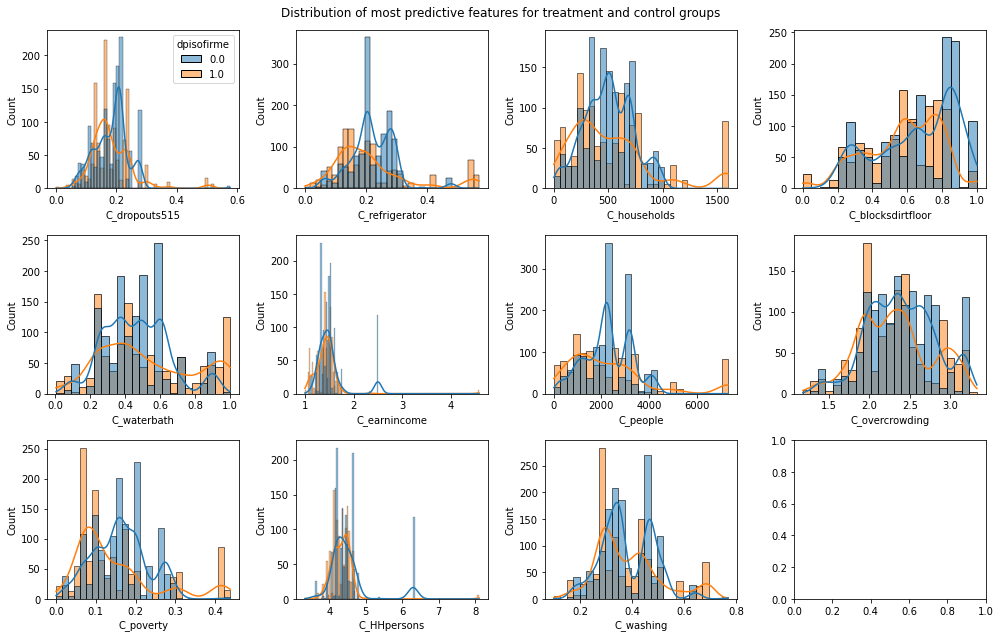

In [96]:
fig, axes = plt.subplots(3, 4, figsize=(14, 9))
fig.suptitle("Distribution of most predictive features for treatment and control groups")

for i, (feature, ax) in enumerate(zip(most_important_features_list, axes.ravel())):
    if i == 0:
        show_legend = True
    else: 
        show_legend = False
    sns.histplot(data=df, x=feature, kde=True, hue='dpisofirme', ax=ax, legend=show_legend)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, 'distribution_of_most_important_features_task_A.png'))

We see that the distribution for the treatment and control groups are indeed relatively different for these features.
It is remarkable that our classifiers are able to take advantage of these differences to such an extent as to perfectly predict the treatment/control labels on a held-out test set.

## Comparison of our feature importances with their _intention-to-treatment_ coefficients

We now compare the feature importances of the outcome variables obtained in the present task, with the coefficients of the _intention-to-treat_ variable that the authors obtain in their regression analyses.

We expect that our feature importances should loosely agree with their coefficients, meaning that the extent to which the _intention-to-treat_ variable is linearly related to a variable is proportional to the importance of this variable to predict the _intention-to-treat_ variable.

We will use the feature importances from the logistic regression because they range over positive as well as negative values, contrarily to the feature importance scores from random forest and XGBoost classifiers.

In [97]:
lr_outcome_importances_series = results_readable_cv_df.loc[:, ('importance_score', 'logistic_regression')].rename('lr_importance_score')

The following cell contains the results reported in Tables 4 and 6 of the paper.

In [98]:
paper_importances_series = pd.Series({
    'S_cementfloorbat': 0.105,
    'S_cementfloorbed': 0.238,
    'S_cementfloordin': 0.21,
    'S_cementfloorkit': 0.255,
    'S_cesds': -2.315,
    'S_pss': -1.751,
    'S_satisfloor': 0.219,
    'S_satishouse': 0.092,
    'S_satislife': 0.112,
    'S_shcementfloor': 0.202,
}).rename('paper_importance_score')

**Table caption:**

Features rankings.
The left-most column shows the features ranked by their paper's coefficients. The second column shows the value of the coefficient.
The two right-most columns show the features ranked by their feature importance scores that we computed above, and the value of the scores.

In [99]:
paper_and_lr_rankings_df = pd.concat([pd.DataFrame(paper_importances_series.sort_values()).reset_index()
                                      .rename(columns={'index': 'paper_ranking'}),
                                      pd.DataFrame(lr_outcome_importances_series.sort_values()).reset_index()
                                      .rename(columns={'variable': 'lr_ranking'})], axis=1) 
paper_and_lr_rankings_df

paper_ranking  paper_importance_score        lr_ranking  \
0            S_cesds                  -2.315           S_cesds   
1              S_pss                  -1.751             S_pss   
2       S_satishouse                   0.092      S_satishouse   
3   S_cementfloorbat                   0.105       S_satislife   
4        S_satislife                   0.112      S_satisfloor   
5    S_shcementfloor                   0.202  S_cementfloorbat   
6   S_cementfloordin                   0.210   S_shcementfloor   
7       S_satisfloor                   0.219  S_cementfloordin   
8   S_cementfloorbed                   0.238  S_cementfloorbed   
9   S_cementfloorkit                   0.255  S_cementfloorkit   
10               NaN                     NaN          baseline   

    lr_importance_score  
0             -0.350029  
1             -0.320553  
2              0.394948  
3              0.624861  
4              1.017018  
5              1.054600  
6              1.056179  
7              1.824472  
8              1.919435  
9              1.930188  
10                  NaN

We first notice that the ranking of importances is almost the same in the paper and in our task:

The only differences are stated in the 3 following bullet points, in which the first rank mentioned corresponds to the paper's, and the second corresponds to our task's:
- `S_satislife` is ranked 4 instead of 3
- `S_shcementfloor` is ranked 5 instead of 6
- `S_satisfloor` is ranked 7 instead of 4

We also note that the sign of the coefficients agree with the sign of the feature importance scores.

We conclude that our feature importance scores agree qualitatively with the coefficients from the paper's regressions.

Let's see to what extent they agree quantitatively.
<!-- Let's see to what extent the order of magnitudes of the feature importances agree with the paper's coefficients. -->

In [100]:
paper_and_lr_importances_df = pd.concat([paper_importances_series.rename('paper_coefficient'), 
                                         lr_outcome_importances_series.rename('lr_importance_score')], axis=1)
paper_and_lr_importances_df.drop(index='baseline', inplace=True)

To ease the comparison, we transform the paper's coefficients and the feature importances to the same range \[0, 1\].

In [101]:
paper_and_lr_importances_minmaxed_df = (paper_and_lr_importances_df
                               .sub(paper_and_lr_importances_df.min(0))
                               .div(paper_and_lr_importances_df.max(0) - paper_and_lr_importances_df.min(0)))

# Compute differences between the two scores
paper_and_lr_importances_minmaxed_df['differences'] = (paper_and_lr_importances_minmaxed_df['paper_coefficient'] 
                                            - paper_and_lr_importances_minmaxed_df['lr_importance_score'])

# Order features by the difference in the two scores
paper_and_lr_importances_minmaxed_df.sort_values('differences', inplace=True)

# Adapt dataframe structure for easy plotting
paper_and_lr_importances_df2plot = paper_and_lr_importances_minmaxed_df.melt(value_vars=['paper_coefficient', 'lr_importance_score'], 
                                                value_name='score',
                                                ignore_index=False).reset_index().rename(columns={'index': 'feature'})

Here we show the paper's coefficients transformed in the range \[0, 1\], along with the importance scores that we obtained for the same features and transformed in the same way.

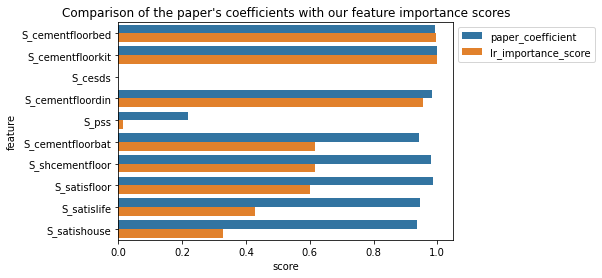

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Comparison of the paper's coefficients with our feature importance scores")
sns.barplot(x='score', y='feature', hue='variable', data=paper_and_lr_importances_df2plot, orient='h', ax=ax)
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(FIGURES_PATH, 'paper_coefs_vs_lr_importance_scores.png'), bbox_inches='tight')

**Observations:**
- The scores are almost the same for 3 of the cement related features (`S_cementfloorbed`, `S_cementfloorkit`, `S_cementfloordin`) and for `S_cesds`, the depression score.
- `S_cementfloorbat`, `S_shcementfloor`, `S_satisfloor` have similar values in terms of the paper coefficients, and also in terms of the feature importance scores. But they all are considered relatively less important by the feature importance scores compared to the paper coefficients.
- The feature for which the two scores differ the most (on a relative scale) is `S_pss`, which represents the perceived stress of the mother of the households.

We conclude that our feature importance scores agree to some extent quantitatively with the paper coefficients. 
But we advise not to rely too much on them, and rather only use the qualitative information of the ranking, which is probably more robust.

## Make tables and figures with Plotly

In [102]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [15]:
# # Load dataframes that take time to compute:
# results_cv_df = pd.read_csv(os.path.join(DATA_PATH, 'classifiers_performances_task_A.csv'))
# with open(os.path.join(DATA_PATH, 'feature_importances_task_A.pickle'), 'rb') as f:
#     importances_cv_df = pickle.load(f)

In [103]:
def get_list_of_series(df):
    """Return the list of series of each column of the dataframe."""
    colnames = df.columns
    return [df[col] for col in colnames]

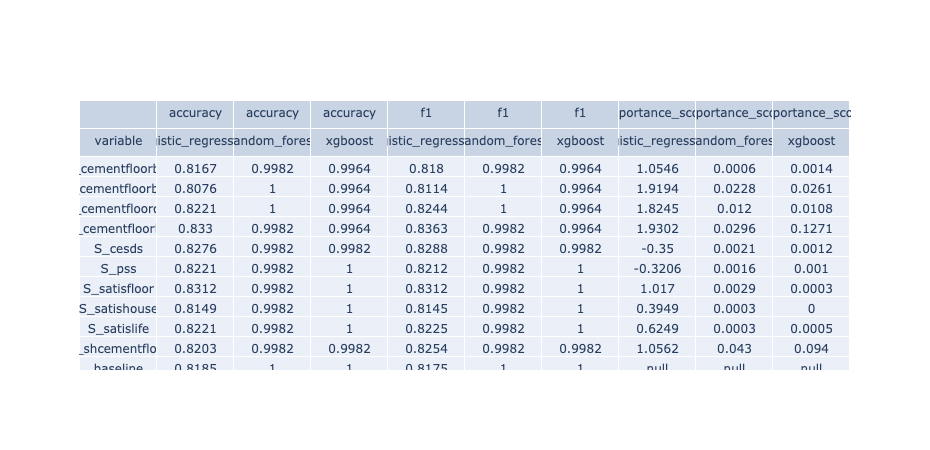

In [41]:
header_list = [('', 'variable')] + list(results_readable_cv_df.columns)
columns_list = [pd.Series(results_readable_cv_df.index)] + get_list_of_series(results_readable_cv_df.round(4))
fig = go.Figure(data=[go.Table(
    header=dict(values=header_list),
    cells=dict(values=columns_list)
)])
fig.show()
fig.write_html(os.path.join(FIGURES_PATH, 'classifiers_performances_table.html'))

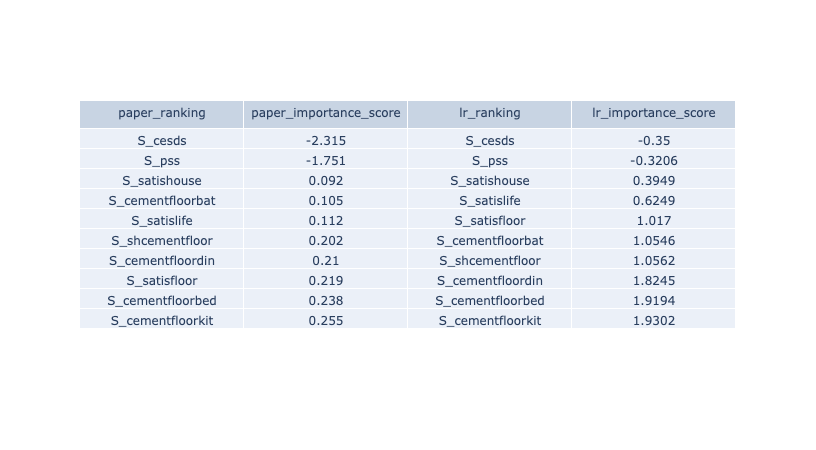

In [50]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(paper_and_lr_rankings_df.columns)),
    cells=dict(values=get_list_of_series(paper_and_lr_rankings_df.iloc[:-1, :].round(4)))
)
                     ])
fig.show()
fig.write_html(os.path.join(FIGURES_PATH, 'coef_and_importance_comparison_table.html'))

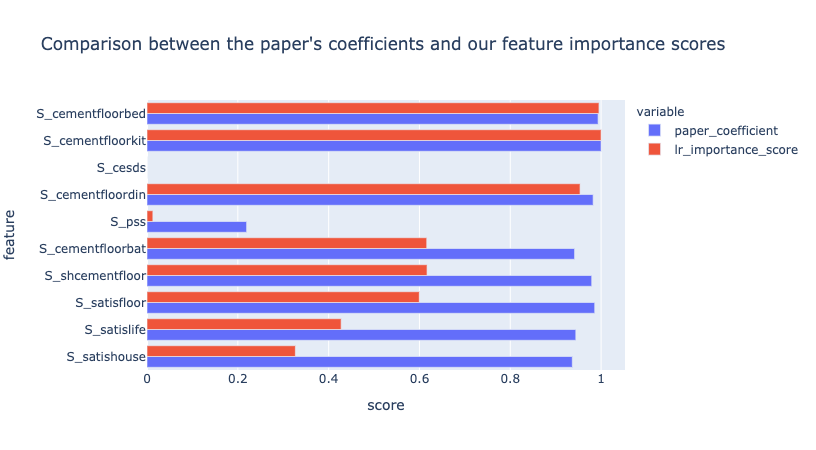

In [101]:
fig = px.bar(paper_and_lr_importances_df2plot.iloc[::-1, :], 
             title="Comparison between the paper's coefficients and our feature importance scores",
             x='score', y='feature', color='variable', barmode='group',
             category_orders={'variable': ['paper_coefficient', 'lr_importance_score']},
             orientation='h')
fig.show()
fig.write_html(os.path.join(FIGURES_PATH, 'coef_and_importance_comparison_barplot.html'))

# Task B
We would like to ask ourselves the question to what extend we can predict the survey data that was collected in 2005 from the census data from 2000.
We will load the dataset, make a comment on the granularity difference of $X$ our feature vectors from the census data and $y$ the target vector from the survey data. We will train a number of models and report their $R^2$ scores. Finally, we will further analyse predictions for selected variables and give our final verdict.

### Outline of Task B
- [Load the dataset](#task_b_load)
- [Difference in granularity of the data](#Difference-in-granularity-of-the-data)
- [
- [Prediction of the multiple survey features](#Prediction-of-the-multiple-survey-features)
- [Analysis for the selected variables](#Analysis-for-the-selected-variables)


## Load the dataset <a name="task_b_load"></a>

In [20]:
df_hh = pd.read_stata('../ada-2020-project-milestone-p2-stima83/Data/PisoFirme_AEJPol-20070024_household.dta')

In [21]:
# We split the dataset into the census (2000) and the survey data (2005)
index_census = list(df_hh.columns[df_hh.columns.str.startswith('C')])
index_survey = list(df_hh.columns[df_hh.columns.str.startswith('S')])
df_hh = df_hh.dropna(subset = index_census + index_survey)
df_census = df_hh[index_census].copy()
df_survey = df_hh[index_survey].copy()

## Difference in granularity of the data
We know that it might be a daunting task as the granularity of the data in the survey data is finer than the one from the census. For every coordinate pair, the survey data contains distinct values for each household. The census data on the other hand contains averaged values over all of the households that have this same coordinate pair. To support this claim, we have included a small script at the beginning of our analysis. This analysis shows already that it will be very difficult to make strong predictions for single households.

In [46]:
result_list = []
for group, df_ in df_hh.groupby(['coord_x', 'coord_y']):
    result_list.append([group, len(df_.value_counts(index_census)), len(df_.value_counts(index_survey))])
df_distinct_values = pd.DataFrame(result_list, columns=['coordinates', 'distinct_census_values', 'distinct_survey_values'])
df_distinct_values

coordinates  distinct_census_values  \
0     (-103.54042053222656, 25.53535270690918)                       1   
1    (-103.53215026855469, 25.572023391723633)                       1   
2    (-103.53031921386719, 25.592403411865234)                       1   
3      (-103.5271224975586, 25.52389907836914)                       1   
4       (-103.5268325805664, 25.5172176361084)                       1   
..                                         ...                     ...   
117  (-103.30526733398438, 25.589887619018555)                       1   
118   (-103.30426025390625, 25.59026527404785)                       1   
119   (-103.30135345458984, 25.59223175048828)                       1   
120  (-103.29920959472656, 25.586183547973633)                       1   
121  (-103.29817962646484, 25.587432861328125)                       1   

     distinct_survey_values  
0                         9  
1                         7  
2                         8  
3                         2  
4                        14  
..                      ...  
117                       3  
118                       2  
119                      28  
120                       2  
121                       5  

[122 rows x 3 columns]

In [51]:
print(f"We have {len(df_distinct_values)} different coordinates pairs and {df_distinct_values['distinct_census_values'].sum()} different census values.")

We have 122 different coordinates pairs and 122 different census values.


## Split into training and testing set 

In [47]:
# Split into test and training set
train_split = 0.7 # We use 70% of the datapoints for training and 30% for testing
train_samples = np.random.rand(df_hh.shape[0]) < train_split
df_census_train = df_census.loc[train_samples]
df_census_test = df_census.loc[~train_samples]
df_survey_train = df_survey[train_samples]
df_survey_test = df_survey[~train_samples]

## Prediction of the multiple survey features
We predict the different survey values from the census data from 2000. We create a data array of the results for the different models. We calculate and report the $R^2$ scores for the different targets of the survey data and the different models.
We use the different models:
- Linear models
    - Linear regression: A simple linear regression is always a good baseline to see how the more advance machine learning techniques perform compared to the linear regressor.
    - Ridge regression: The Ridge regression use a L2 regularization term that penalizes the size of the coefficients and 'shrinks' these coefficients. Therefore, the model becomes more robust to collinearity.
- Non-linear models
    - DecisionTreeRegressor: A decision tree is build from the data and can have a very high depht.
    - GradientBoostingRegressor: Builds a certain number of weak learners (decsion trees with a shallow depht) and combine these in order to have a strong prediction. 
    - MLPRegressor: The multi-layer perceptron is a fully connected neural network that is able to build complex non linear models.

In [23]:
def generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models):
    """Create the dataframe of the different predictions for every model summarized by an R^2 score."""
    results = np.zeros((len(selected_models), len(df_survey_train.columns)))
    for i, model in enumerate(selected_models):
        for j, (column_name, column_data) in enumerate(df_survey_train.iteritems()):
            model.fit(df_census_train, column_data)
            results[i,j] = model.score(df_census_test, df_survey_test[column_name])
    string_selected_models = [re.match(r'([a-zA-Z]+)\(.+', str(model)).group(1) for model in selected_models]
    return pd.DataFrame(results, columns=df_survey_train.columns, index=string_selected_models)

def wrapper_generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models, standardize_=True):
    """Wrapper function for generate_prediction_df where we standardize the dataset before training the models."""
    if standardize_:
        df_census_train, df_census_test = standardize(df_census_train, df_census_test) 
    df_results = generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models)
    return df_results

In [24]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

selected_models = [LinearRegression(),
                   Ridge(),
                   DecisionTreeRegressor(),
                   GradientBoostingRegressor(),
                   MLPRegressor(max_iter=3000, learning_rate_init=0.1, learning_rate='adaptive',hidden_layer_sizes=(50,), )]
# We use the standard parameters for all the models except for the MLP. For the MLP, we tried different values but we could
# not really find a value that was much better than another one. We use an adaptive learning rate of 0.1 and 50 hidden layers. 

We calculate the $R^2$ score with a standardized and non-standardized dataset. Different algorithms improve in performance when standardizing and others have in general no need for standardization like the Gradient Boosting Regressor. We will see how the different algorithms behave in the following.

In [25]:
# Without standardization
df_results = wrapper_generate_prediction_df(df_census_train, 
                                            df_census_test, 
                                            df_survey_train,
                                            df_survey_test,
                                            selected_models,
                                            standardize_=False)

In [96]:
# With standardization
df_results_standardized = wrapper_generate_prediction_df(df_census_train, 
                                                         df_census_test,
                                                         df_survey_train,
                                                         df_survey_test,
                                                         selected_models,
                                                         standardize_=True)

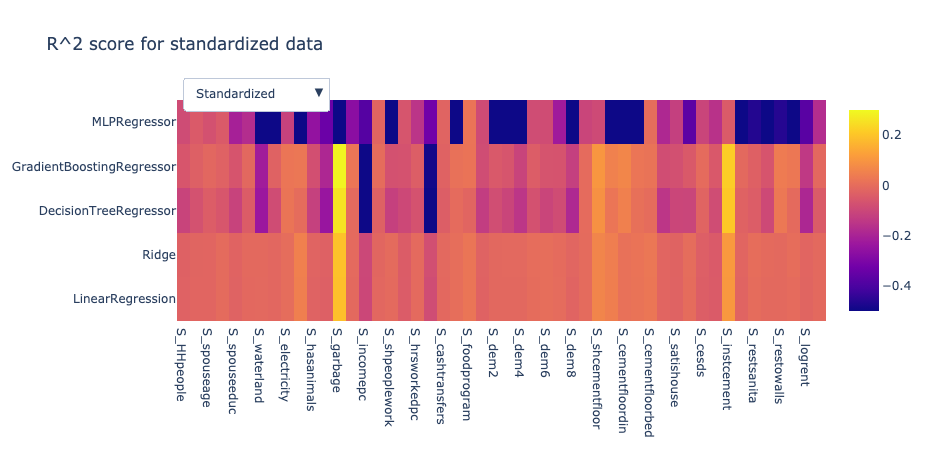

In [52]:
fig = go.Figure()

fig.add_trace(go.Heatmap(   x = df_results.columns,
                            y = df_results.index,
                            z = df_results.values,
                            name = 'Non standardized',
                            zmin= -0.5,
                            zmax = 0.3))

fig.add_trace(go.Heatmap(   x = df_results_standardized.columns,
                            y = df_results_standardized.index,
                            z = df_results_standardized.values,
                            name = 'Standardized',
                            zmin= -0.5,
                            zmax = 0.3))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    method="update",
                    args=[{"visible": [False, True]},
                           {"title": "R^2 score for standardized data"}],
                    label="Standardized"
                    
                ),
                dict(
                    method="update",
                    args=[{"visible": [True, False]},
                           {"title": "R^2 score for non-standardized data"}],
                    label="Non standardized"
                    
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.layout.title = "R^2 score for standardized data"
fig.write_html('../figures/taskb_R2_scores_heatmap.html')
fig.show(auto_open=False)

The heatmap that summarizes the results of our predictions from the different algorithms is very dense in information. Therefore, we need to make further analysis in the following. We clearly notice that the MLP performs quite badly in our test (even after trying to optimize the parameters.) Therfore, we will not consider this model in the follwing analysis. The cause of the bad performance might be the lack if enough datapoints. We only have 1390 datapoints for the training set. This might explain the bad performance of the MLP.

In [ ]:
df_results = df_results.drop(index=['MLPRegressor'])
df_results_standardized = df_results_standardized.drop(index=['MLPRegressor'])

### Comparison between mean performance of the different algorithms

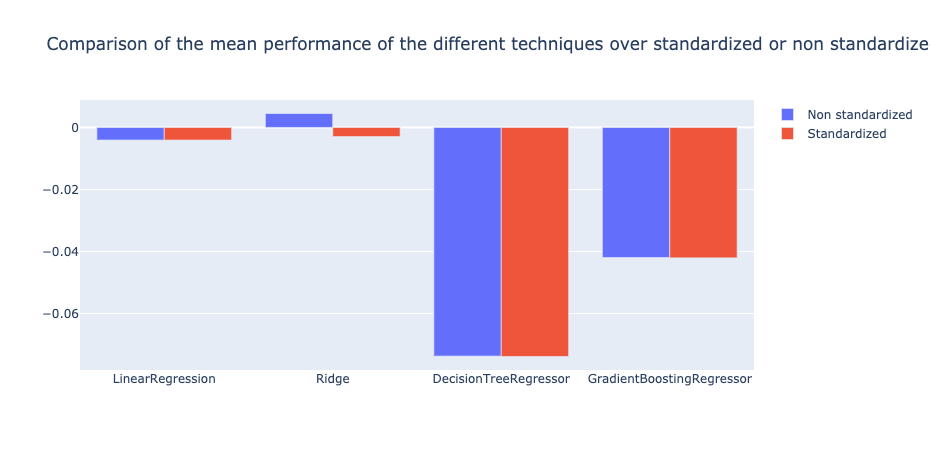

In [99]:
fig = go.Figure()
df_result_average = df_results.mean(axis=1)
df_result_stand_average = df_results_standardized.mean(axis=1)
fig.add_trace(go.Bar(x = df_result_average.index, y=df_result_average.values, name='Non standardized'))
fig.add_trace(go.Bar(x = df_result_stand_average.index, y=df_result_stand_average.values, name='Standardized'))
fig.update_layout(title=go.layout.Title(text="Comparison of the mean performance of the different \
techniques over standardized or non standardized data"))
fig.show()
fig.write_html('../figures/taskb_mean_r2_performance_all_predictions.html')

When we compare the results  between the different average performances of our five regressors, we notice that the overall performance of all the regressors are not very good. The Linear and Ridge Regressor seem to have the best performance than the non-linear regressor. This is mostly explained by the fact that they don't have a very bad performance on variables that are difficult to predict. The non-linear techniques perform far better than the non-linear ones on some variables, where a good prediction seems  to be feasible. We will in the following analysis focus on the variables for which we can make a meaningful prediction and compare the different models for these. 

In [100]:
chosen_variables = df_results.mean(axis=0).sort_values(ascending=False)[:5]
chosen_variables

S_garbage           0.232318
S_instcement        0.158125
S_shcementfloor     0.077114
S_cementfloorkit    0.042787
S_cementfloordin    0.036036
dtype: float64

In [101]:
chosen_variables = list(chosen_variables.index)

We computed the mean $R^2$ score for all the variables over all the models and choose the five variables for which we can potentially make a meaningful prediction. 

Let's graph the R^2 score for the different models in a barplot again.

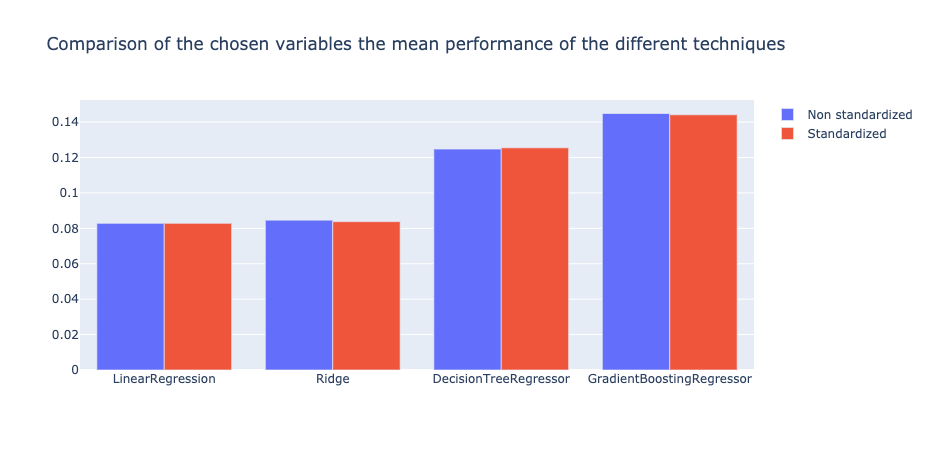

In [102]:
# chosen_variables = chosen_variables
df_results_chosen = df_results[chosen_variables]
df_results_standardized_chosen = df_results_standardized[chosen_variables]
fig = go.Figure()
df_result_average_chosen = df_results_chosen.mean(axis=1)
df_result_stand_average_chosen = df_results_standardized_chosen.mean(axis=1)
fig.add_trace(go.Bar(x = df_result_average_chosen.index, y=df_result_average_chosen.values, name='Non standardized'))
fig.add_trace(go.Bar(x = df_result_stand_average_chosen.index, y=df_result_stand_average_chosen.values, name='Standardized'))
fig.update_layout(title=go.layout.Title(text="Comparison of the chosen variables the mean performance of the different techniques"))
fig.show()
fig.write_html('../figures/mean_r2_performance_chosen_predictions.html')

This plot offers a very different picture on the performance of the different regressors. The Linear and the Ridge regression perform very similarly. The non-linear methods perform better than the linear techniques. The gradient boosting method is able to deliver the best results. For the Gradient Boosting, the standardization does not improve the score and we will just use the non standardized data in the following.

## Analysis for the selected variables
In the following, we will focus on the selected variables and analyse if we can predict them from the census data from 2000. We will use the Gradient Bosting Regressor as its overall performance was the best. We will also analyse what features are the most important in the prediction of the variable. We will plot the feature importances for the different predictions. We still need to be careful with high cardinality features of the impurity-based feature importance scores (high cardinality tends to have a higher feature importance score). Moreover, the impurity-based feature importance score will not be meaningful if we have correlated features. One correlated feature might have a very high score while the other one is very small. Therefore, we use the permutation feature score on test data to reanalyse the feature importances. The idea of the permutation feature score is to test the influence of a feature immediatly on the model. For unimportant features, the have little effects on the predictive power of the model and the permutation of important feature should have a big negative influence on the predictive power. (Source: We have used some explainations from https://blog.datadive.net/selecting-good-features-part-iii-random-forests/, https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

### Functions

In [138]:
def plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, model, survey_targets):
    fig = make_subplots(rows=2, cols=1)
    for target in survey_targets:
        model.fit(df_census_train, df_survey_train[target])
        feature_importances = model.feature_importances_
        df_feature_importances = pd.DataFrame(feature_importances, index=df_census_train.columns, columns=['Feature importance']).sort_values('Feature importance', ascending=False)
        fig.add_trace(go.Bar(x = df_feature_importances.index, y=df_feature_importances['Feature importance']), row=1, col=1)
        results = permutation_importance(model, df_census_test, df_survey_test[target], n_repeats=100, random_state=42, n_jobs=2)['importances']
        df_results = pd.DataFrame(results.T, columns=df_census.columns)
        df_results = df_results[df_feature_importances.index]
        fig2 = px.box(pd.melt(df_results), x='variable', y='value')
        fig.add_trace(fig2.data[0], row=2, col=1)
    fig.update_layout(title=go.layout.Title(text=f"Impurity based feature importance and permutation importance for {survey_targets[0]}"))
    fig.update_layout(showlegend=False)
    fig.write_html(f'../figures/taskb_feature_importance_{survey_targets[0]}.html')
    fig.show()
    
    
from sklearn.ensemble import GradientBoostingClassifier
def plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, model, survey_targets):
    fig = go.Figure()
    for target in survey_targets:
        model.fit(df_census_train, df_survey_train[target])
        prediction = model.predict(df_census_test)
        fpr, tpr, thresholds = roc_curve(df_survey_test[target], prediction)
        auc_metric = roc_auc_score(df_survey_test[target], prediction)
    print(f'The Area Under ROC curve is {auc_metric}')
    label_dict = {'x':'False positive rate', 'y':'True positive rate'}
    fig = px.line(x=fpr, y=tpr, width=600, height=600, title=f'ROC curve for {target}', labels=label_dict)
    fig.update_layout(showlegend=False)
    fig.write_html(f'../figures/taskb_AUC_curve_{survey_targets[0]}.html')
    fig.show()

### S_garbage
#### Def: This is a binary variable that tells us if this households have access to garbage collection service.

In [103]:
df_hh['S_garbage'].value_counts()

1.0    1617
0.0     336
Name: S_garbage, dtype: int64

This is a binary value, which tells us if we use garbage collection. In this case, we can use a classification algorithm and see how easily we can predict this value. Most of the households dispose of garbage collection, therefore we should not use the naive accuracy score to judge the quality of our prediction. The naive prediction of saying that we predict that all the households have garbage collection leads to an accuracy score of $\frac{1617}{1617+336}\ =\ 0.830$. This score would give the impression that our predictions is good even if it does not provide is any additional information. In order to better judge the quality of the predictor, we will plot the Receiver Operating Characteristic (ROC) curve and provide the Area Under Plot (AUC) score. The ROC curve is able to illustrate the quality of a predictor by ploting the False positive rate ($\text{FP rate} = \frac{\text{FP}}{\text{FP}+\text{TN}}$, $\text{TP rate} = \frac{\text{TP}}{\text{FP}+\text{FN}}$) against the True positive rate for different threshold levels. The AUC score summarizes this plot in a meaningful way by calculating the area under this curve. The closer it is to 1, the better the prediction is. A score of 0.5 means, that the performance of the regressor is randomly guessing.

The Area Under ROC curve is 0.8465780460904393


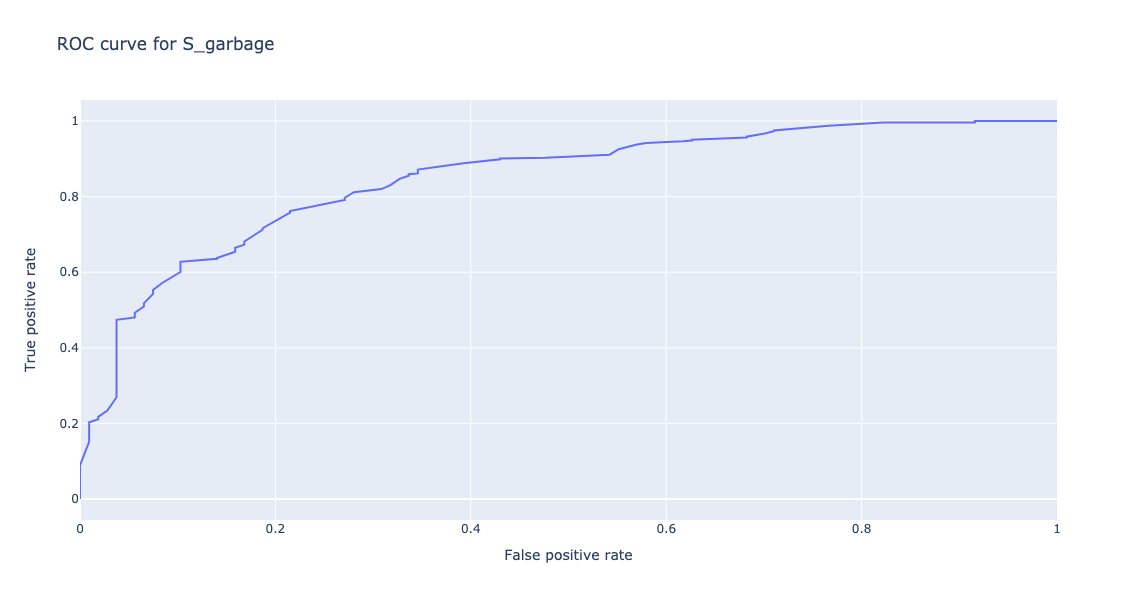

In [113]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_garbage'])

Our model performs in a decent way on this variable and can often predict what households will get garbage collection from the census data. In the following, we will analyse how important the different features were in the prediction.

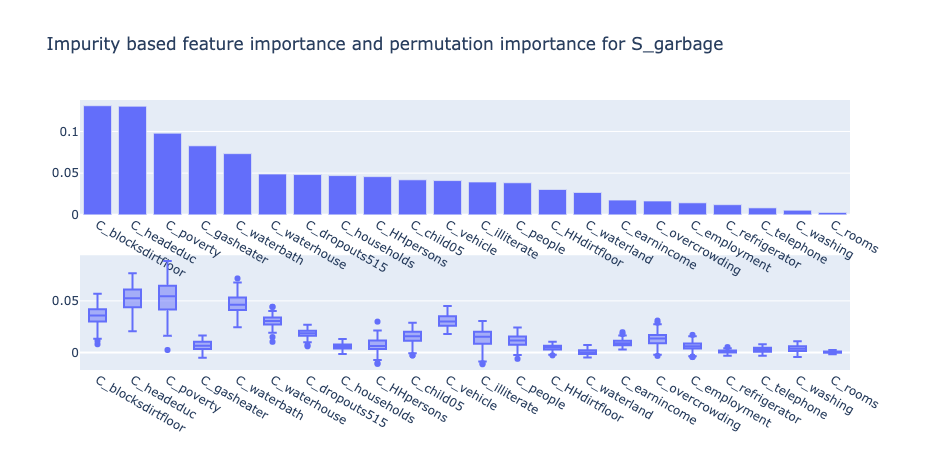

In [139]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_garbage'])

Both plots we produce give a very different picture of the feature importance. Some of the features are important in both plots, but some are also overestimated in the impurity-based feature importance analysis. Examples for features that are overestimated are `C_blocksdirtfloor` and `C_gasheater`. These two variables have a high cardinality of 93 for the `C_blocksdirtfloor` and 109 for `C_gasheater`. 

Good indicators to predict if the household has garbage collection 5 years into the future are `C_poverty` and `C_headeduc`. We can only hypotheszise why these two features are the most important:
- `C_poverty`: Most of the household that are economically better of have already garbage collection in 2000. Therefore the interesting part is to predict if the poorest of the households will have garbage collection. Government programs might also focus the most on the poorest households. This makes this variable quite important. We need to notice that the confidence interval for this variable is very large.
- `C_headeduc`: The average number of schooling years of an household might be predictive in a sense that an educated person will know about the importance of garbage collection service for the general hygiene and will also be able to articulate their needs to the institution that takes care of the garbage collection. 
We are very aware that these kind of hypothesis need to be taken with a grain of salt. The predictions are not very good and tree learners have a tendency of overfitting.

In [140]:
len(df_census_train['C_blocksdirtfloor'].unique())

93

In [141]:
len(df_census_train['C_gasheater'].unique())

109

### S_instcement
#### Def: Indicator equal to one if the household reports having installed a cement floor since 2000.

In [142]:
df_hh['S_instcement'].value_counts()

1.0    1381
0.0     572
Name: S_instcement, dtype: int64

The Area Under ROC curve is 0.7977457325283412


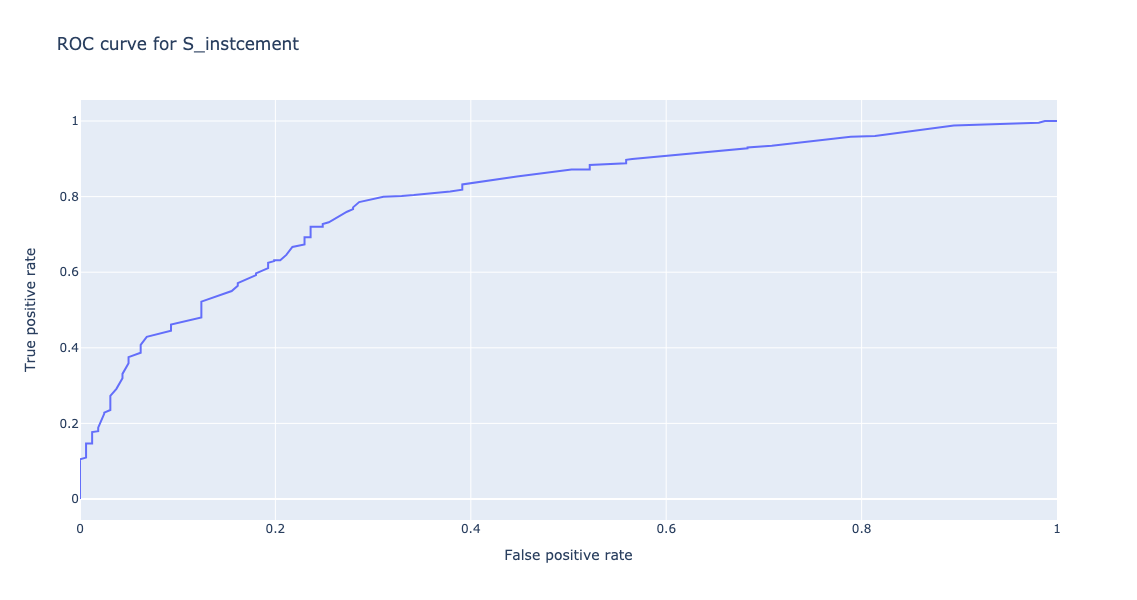

In [143]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_instcement'])

Again the predictions of our model are decent. We will turn our focus towards the feature importance of our prediction.

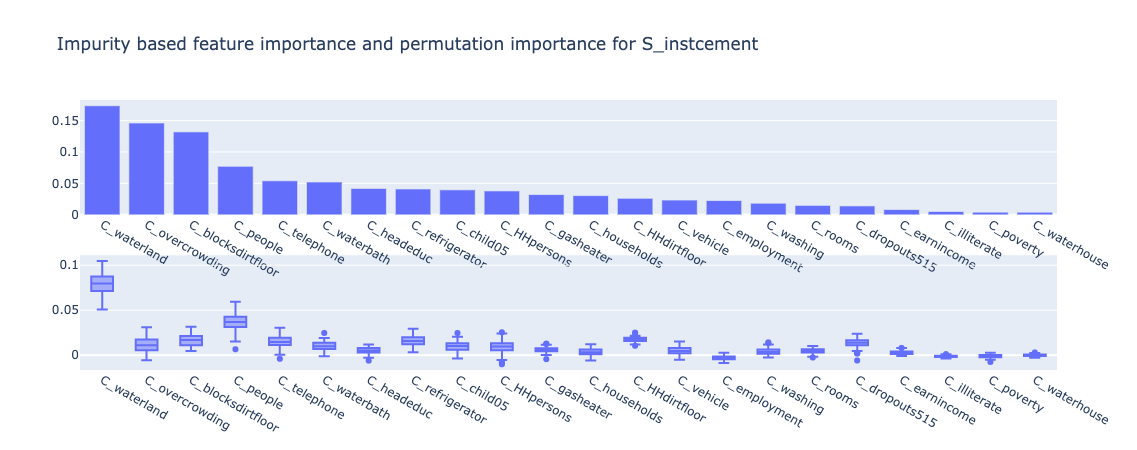

In [144]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_instcement'])

We will only consider the second subplot based on the permutation importances for our analysis. `C_waterland` and `C_people` seem to be the greatest predictor if a household will get cement floor in between 2000 and 2005. `C_waterland` is the proportion of household that has no water connection outside the house and `C_people` is the cumulated number of people. 
We can again hypothezise why these two values are the most important ones:
- We could not come up with an intuitive explaination for the importance of the `C_waterland` variable.
- If a lot of people live in a certain area, the government might turn its attention more easily towards these households. Therefore, they might have higher probabilities of profiting from such a program. 

### S_cementfloordin and S_cementfloorkit
#### Def: Cement floor in dining room and in the kitchen
We will treat both predictions in this subsection because it could be interesting to compare the results for both. 

In [145]:
df_hh['S_cementfloordin'].value_counts()

1.0    1589
0.0     364
Name: S_cementfloordin, dtype: int64

The Area Under ROC curve is 0.7227214252300014


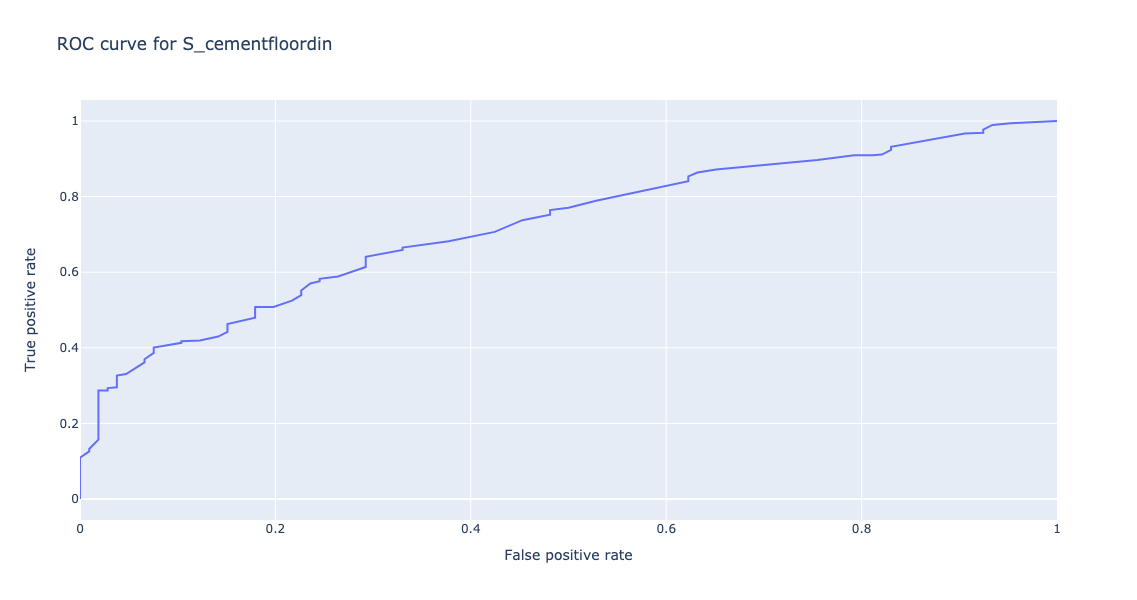

In [154]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloordin'])

The Area Under ROC curve is 0.7104254948627156


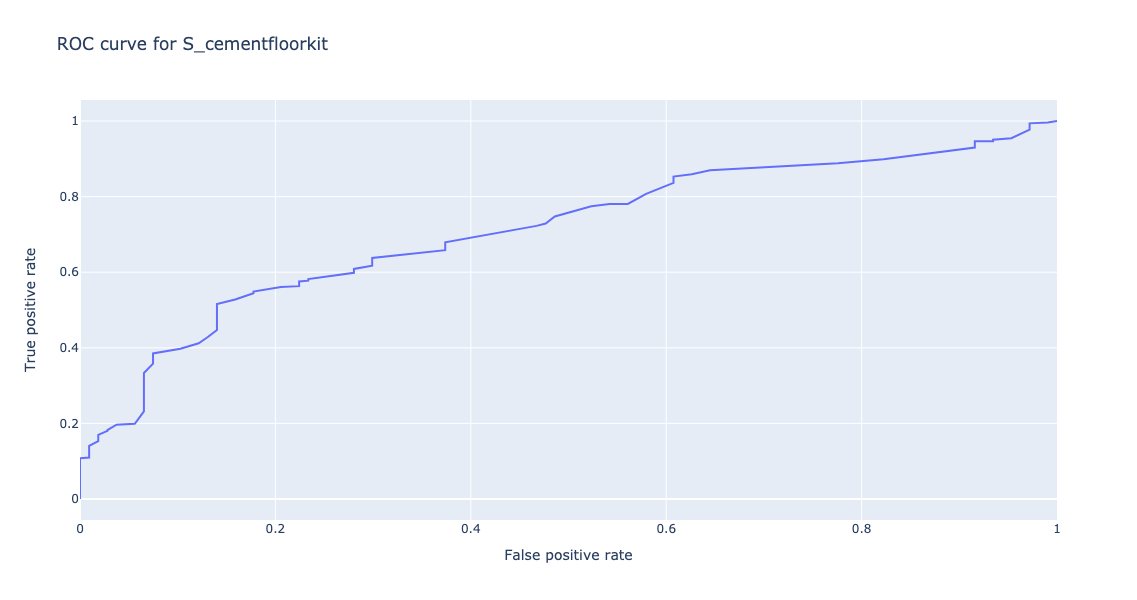

In [155]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloorkit'])

Both predictions are acceptable and there quality is quite similar.

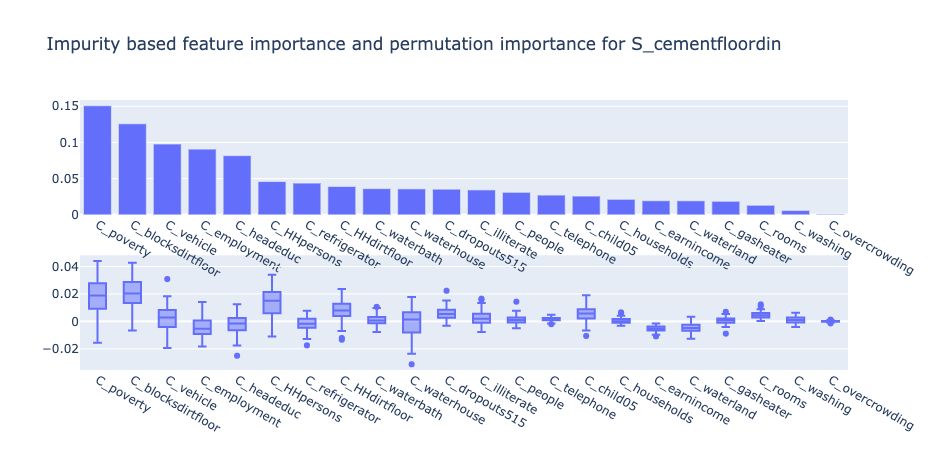

In [147]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloordin'])

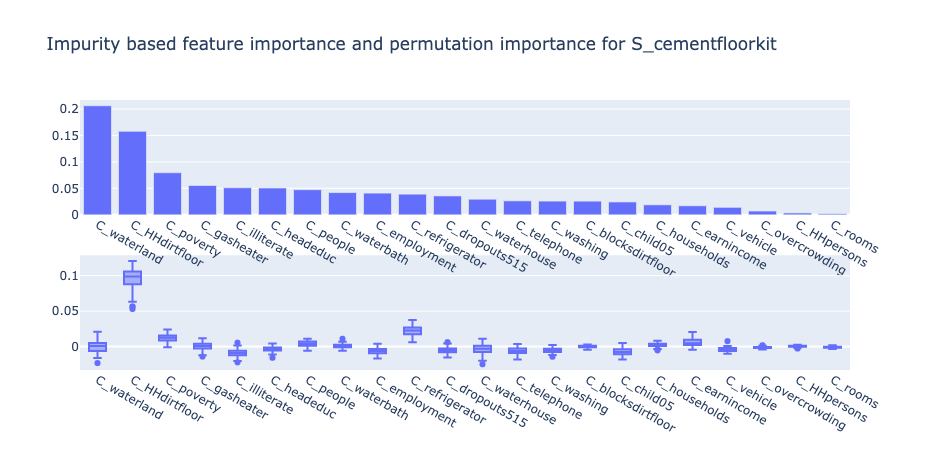

In [153]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloorkit'])

In [185]:
(df_hh['S_cementfloorkit'].astype(int).astype(str) + df_hh['S_cementfloordin'].astype(int).astype(str)).value_counts()

11    1481
00     293
01     108
10      71
dtype: int64

The incidence of people having a cement floor in the dinning room before having a cement floor in the kitchen is slighly bigger as we can see. 108 households that don't have a cement floor in the kitchen, have a cement floor in the dining room compared to 71 households where it is the other way around.

`S_cementfloordin` does not really have features that are much more important than other when we consider the permutation importance scores. So an analysis is rather difficult. For `S_cementfloorkit`, we have `C_HHdirtfloor` and a little less important `C_refrigerator`. We hypothezise:
-`C_HHdirtfloor`: We don't really know why this feature would be more important particularly to predict the presence of cement floor in the kitchen. By the little analysis just above, we could show that often the kitchen is one of the last rooms that gets a concrete floor. Therefore, the information what proportion of dirtfloors are in the households might be particularly important.
-`C_refrigerator`: This value seems to influence the prediction also in a meaningful way. this might make sense, because the presence of a refrigerator might indicate if a kitchen is often used and how the hygienic standards are in this particular household. If the kitchen is often used and standards are high, the investment in a concrete floor is more probable.

### S_shcementfloor
Def: Share of rooms with cement floors

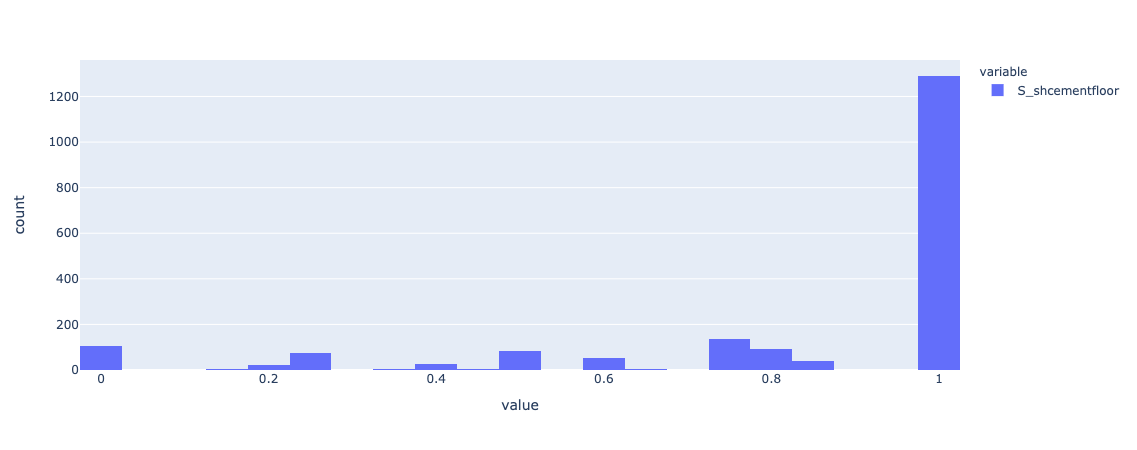

In [148]:
import plotly.figure_factory as ff
px.histogram(df_hh['S_shcementfloor'], ['S_shcementfloor'])

Most of the households have already 100% concrete floors. The other households have different shares of concrete floors. 106 households live in particularly difficult circumstances without any concrete floors in their home. 

In [189]:
model = GradientBoostingRegressor()
model.fit(df_census_train, df_survey_train['S_shcementfloor'])
result = model.score(df_census_test, df_survey_test['S_shcementfloor'])
result

0.10252212344660794

The results are not very good. From census data it seems to be difficult to infer the proportion of concrete floors 5 years later.

## Overall conclusions
We see that in general the census data from 2000 does not allow us to construct a good model to predict the different features of the survey in 2005. This is not astonishing as the census data has less granularity than the survey data that is specific to every household. The cenus data mostly reports averages over an area that is composed of many households. There are still a few values, where some algorithms are able to make decent predictions. 
We conclude that we are only able to make weak predictions for a certain reduced number of survey variables.